<center>
<img src="../ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 
## <center> Обучение без учителя

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/19oWnb5CxC5g-Zn45VWjuq_OP8YPCrn_g8Wq3aMaW2U4).

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from collections import OrderedDict

RANDOM_STATE = 17

In [10]:
X_train = np.loadtxt('./data/samsung_train.txt')
y_train = np.loadtxt('./data/samsung_train_labels.txt').astype(int)

X_test = np.loadtxt('./data/samsung_test.txt')
y_test = np.loadtxt('./data/samsung_test_labels.txt').astype(int)

In [11]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [95]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [98]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [99]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [22]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [155]:
# Ваш код здесь
pca = PCA(n_components=65, random_state=RANDOM_STATE)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=65, random_state=17,
  svd_solver='auto', tol=0.0, whiten=False)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [156]:
np.sum(pca.explained_variance_ratio_)

0.8997840389399011

In [157]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
pca.fit(X_scaled)
pca.n_components_

65

**Варианты:**
- 56 
- 65
- 66
- 193

In [39]:
np.cumsum(pca.explained_variance_ratio_)[0]

0.5073822103501335

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [41]:
pca = PCA(random_state=RANDOM_STATE, n_components=65)
X_pca = pca.fit_transform(X_scaled)

Визуализируйте данные в проекции на первые две главные компоненты.

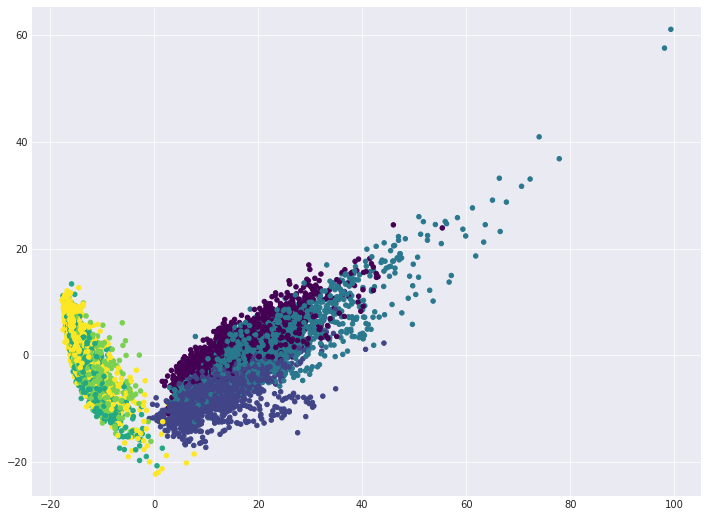

In [100]:
pca_scatter = PCA(random_state=RANDOM_STATE, n_components=2)
X_pca_scatter = pca_scatter.fit_transform(X_scaled)
plt.scatter(X_pca_scatter[:, 0], X_pca_scatter[:, 1], c=y, s=20, cmap='viridis')

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [60]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=17, tol=0.0001, verbose=0)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

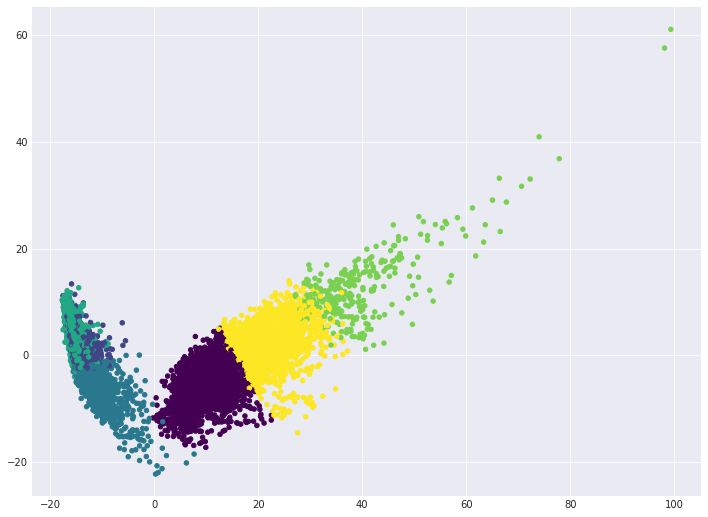

In [101]:
# Ваш код здесь
cluster_labels = kmeans.labels_
plt.scatter(X_pca_scatter[:, 0], X_pca_scatter[:, 1],
            c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [102]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,904,0,0,0,78,740,1722
подъем вверх по лестнице,1242,0,2,0,5,295,1544
спуск по лестнице,320,0,0,0,196,890,1406
сидение,1,1235,450,91,0,0,1777
стояние,0,1344,562,0,0,0,1906
лежание,5,53,329,1557,0,0,1944
все,2472,2632,1343,1648,279,1925,10299


In [103]:
for col in tab.columns:
    tab[col + 'metric'] = tab[col] / tab['все']
    
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все,cluster1metric,cluster2metric,cluster3metric,cluster4metric,cluster5metric,cluster6metric,всеmetric
ходьба,904,0,0,0,78,740,1722,0.524971,0.000000,0.000000,0.000000,0.045296,0.429733,1.0
подъем вверх по лестнице,1242,0,2,0,5,295,1544,0.804404,0.000000,0.001295,0.000000,0.003238,0.191062,1.0
спуск по лестнице,320,0,0,0,196,890,1406,0.227596,0.000000,0.000000,0.000000,0.139403,0.633001,1.0
сидение,1,1235,450,91,0,0,1777,0.000563,0.694992,0.253236,0.051210,0.000000,0.000000,1.0
стояние,0,1344,562,0,0,0,1906,0.000000,0.705142,0.294858,0.000000,0.000000,0.000000,1.0
лежание,5,53,329,1557,0,0,1944,0.002572,0.027263,0.169239,0.800926,0.000000,0.000000,1.0
все,2472,2632,1343,1648,279,1925,10299,0.240023,0.255559,0.130401,0.160016,0.027090,0.186911,1.0


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- нет верного ответа

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [104]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

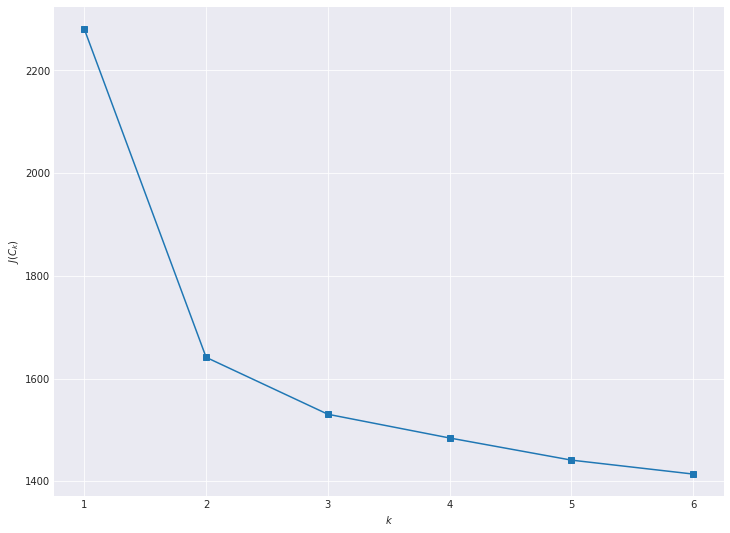

In [106]:
plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [108]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [111]:
# Ваш код здесь
print('AgglomerativeClustering - %s' % metrics.adjusted_rand_score(y, ag.labels_))
print('KMeans - %s' % metrics.adjusted_rand_score(y, cluster_labels))

AgglomerativeClustering - 0.4880109976849711
KMeans - 0.4196778456687551


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), примените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [112]:
# Ваш код здесь
#
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [113]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [118]:
# Ваш код здесь
grid = GridSearchCV(svc, svc_params, cv=3, verbose=1).fit(X_train_scaled, y_train)
best_svc = grid.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   46.9s finished


In [120]:
grid.best_score_, grid.best_params_

(0.9382480957562568, {'C': 0.1})

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

In [121]:
y_predicted = best_svc.predict(X_test_scaled)

In [122]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


In [135]:
preccision_classes = [tab.values[i][i] / tab.values[-1][i] for i in range(n_classes)]
list(sorted(zip(preccision_classes, tab.columns[:-1])))

[(0.8777589134125636, 'стояние'),
 (0.9638009049773756, 'сидение'),
 (0.9724409448818898, 'ходьба'),
 (0.9786780383795309, 'подъем вверх по лестнице'),
 (1.0, 'лежание'),
 (1.0, 'спуск по лестнице')]

In [136]:
recall_classes = [tab.values[i][i] / tab.values[i][-1] for i in range(n_classes)]
list(sorted(zip(recall_classes, tab.columns[:-1])))

[(0.8676171079429735, 'сидение'),
 (0.9718045112781954, 'стояние'),
 (0.9745222929936306, 'подъем вверх по лестнице'),
 (0.9795158286778398, 'лежание'),
 (0.9833333333333333, 'спуск по лестнице'),
 (0.9959677419354839, 'ходьба')]

**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – стояние, по полноте – сидение 

In [137]:
pca = PCA(n_components=65).fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [138]:
svc_pca = LinearSVC(random_state=RANDOM_STATE)

In [142]:
grid_pca = GridSearchCV(svc, svc_params, cv=3, verbose=1).fit(X_train_scaled_pca, y_train)
best_svc_pca = grid_pca.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   11.3s finished


In [143]:
grid_pca.best_score_, grid_pca.best_params_

(0.9019314472252449, {'C': 1})

In [144]:
y_predicted_pca = best_svc_pca.predict(X_test_scaled_pca)

In [146]:
(metrics.accuracy_score(y_test, y_predicted) - metrics.accuracy_score(y_test, y_predicted_pca)) * 100

3.868340685442817

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком